### Bayesian optimization

Optimize our AE using a bayesian optimization, with the AUC as the 'score' to regress upon

##### imports

Import `skopt`

In [1]:
import autoencodeSVJ.evaluate as ev
import autoencodeSVJ.utils as utils
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np

Using TensorFlow backend.


In [3]:
space = [
#     Integer(2, 30, name='target_dim'),
#     Integer(0, 1, name='hlf'),
    Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'), 
#     Integer(3, 4, name='eflow_base')
]

In [4]:
filtered = utils.summary().cfilter([elt.name for elt in space] + ["*auc"])

keep = filtered.copy()
for elt in space:
    if isinstance(elt, Categorical):
        keep = keep[keep[elt.name].isin(elt.categories)]
    else:
        keep = keep[keep[elt.name].between(*elt.bounds)]
        if isinstance(elt, Integer):
            keep = keep[keep[elt.name].apply(lambda x: float(x).is_integer())]

aucs = keep.loc[:,~keep.columns.isin([elt.name for elt in space])]

x0 = np.asarray([keep[item.name].values for item in space]).T.tolist()
y0 = map(lambda x: 1 - x,aucs.max(axis=1).tolist())
# x0 = [list(keep [item.name].values) for item in space]
# y0 = auc.max(axis=1).tolist()

In [5]:
random_state = 42

@use_named_args(space)
def objective(**X):
    print "computing configuration {}".format(X)
    
    # minimize 1 - auc
    auc = 1. - ev.ae_train(
        qcd_path='data/background/base_{}/*.h5'.format(4),
        signal_path="data/signal/base_{}/*.h5".format(4),
        epochs=100,
        hlf=1,
        eflow=1,
        target_dim=15,
#         val_split=X['val_split'],
        learning_rate=X['learning_rate'],
        optimizer='adam',
#         loss=X['loss'],
        loss='mse',
        seed=random_state,
        verbose=0,
    )
    
    print "Max AUC:", 1 - auc
    return auc

results = gp_minimize(
    objective, space, verbose=1, 
    n_calls=20, 
    n_random_starts=5, 
    random_state=random_state
)

Iteration No: 1 started. Evaluating function at random point.
computing configuration {'learning_rate': 0.024526126311336792}
Max AUC: 0.958374110805
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 32.7131
Function value obtained: 0.0416
Current minimum: 0.0416
Iteration No: 2 started. Evaluating function at random point.
computing configuration {'learning_rate': 0.00035506214270707701}
Max AUC: 0.978091041411
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 138.8298
Function value obtained: 0.0219
Current minimum: 0.0219
Iteration No: 3 started. Evaluating function at random point.
computing configuration {'learning_rate': 0.021830968390524622}
Max AUC: 0.877596151068
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 30.8410
Function value obtained: 0.1224
Current minimum: 0.0219
Iteration No: 4 started. Evaluating function at random point.
computing configuration {'learning_rate': 0.0061737703947045792}
Max AUC: 0.986598173454


/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Max AUC: 0.974274782925
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 183.1359
Function value obtained: 0.0257
Current minimum: 0.0134
Iteration No: 8 started. Searching for the next optimal point.
computing configuration {'learning_rate': 0.0001}
Max AUC: 0.974274782925
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 186.9723
Function value obtained: 0.0257
Current minimum: 0.0134
Iteration No: 9 started. Searching for the next optimal point.
computing configuration {'learning_rate': 0.0001}
Max AUC: 0.97100948627
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 189.9427
Function value obtained: 0.0290
Current minimum: 0.0134
Iteration No: 10 started. Searching for the next optimal point.
computing configuration {'learning_rate': 0.0001}
Max AUC: 0.974274782925
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 193.3130
Function value obtained: 0.0257
Current mini

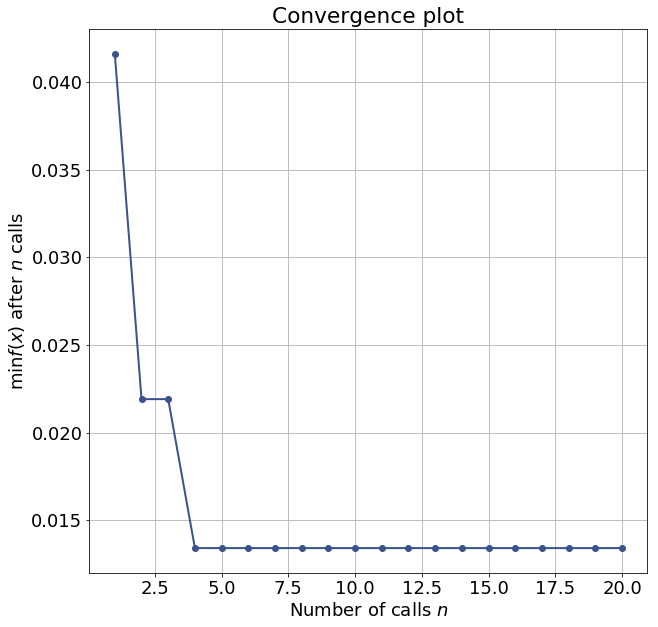

In [6]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(results)
plt.show()

In [7]:
print "Best parameters:"
for i,elt in enumerate(space):
    print "{} = {}".format(elt.name, results.x[i])

Best parameters:
learning_rate = 0.0061737703947


In [13]:
utils.summary().cfilter(['*auc', 'filename', 'target_dim', '*?time', 'input_dim']).sort_values('mae_auc')[::-1][utils.summary().hlf == 1].head(20)

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,end_time,filename,input_dim,mae_auc,mse_auc,start_time,target_dim
27,2019-08-05 20:14:47.190888,hlf_eflow3_15_v1,19,0.990073,0.989479,2019-08-05 20:11:26.819727,15
177,2019-08-06 19:15:35.809454,hlf_eflow4_15_v4,42,0.985357,0.986598,2019-08-06 19:13:20.649385,15
171,2019-08-06 19:08:56.309025,hlf_eflow4_18_v0,42,0.984906,0.984036,2019-08-06 19:06:21.995492,18
11,2019-08-05 19:01:09.524812,hlf_eflow3_27_v0,19,0.984777,0.985934,2019-08-05 18:59:06.628314,27
25,2019-08-05 20:09:15.784651,hlf_eflow4_26_v0,42,0.98439,0.982264,2019-08-05 20:06:56.268856,26
184,2019-08-06 19:26:01.700215,hlf_eflow4_24_v0,42,0.984042,0.984014,2019-08-06 19:22:42.591941,24
195,2019-08-06 19:43:14.635878,hlf_eflow4_15_v13,42,0.983685,0.983041,2019-08-06 19:40:06.115535,15
37,2019-08-05 20:45:45.521284,hlf_eflow3_30_v1,19,0.983567,0.981455,2019-08-05 20:41:04.158394,30
188,2019-08-06 19:32:16.192568,hlf_eflow4_26_v1,42,0.983308,0.982533,2019-08-06 19:28:48.415677,26
167,2019-08-06 18:59:05.210337,hlf_eflow4_14_v0,42,0.982527,0.982239,2019-08-06 18:56:42.957397,14
